# Model Comparison with Nested Sampling: Galaxy Kinematic Populations

In this tutorial, we will apply Bayesian model comparison using nested sampling to real astronomical data from the SAMI Galaxy Survey. Our goal is to determine whether the distribution of galaxy spin parameters ($\lambda_{R_e}$) is better described by one or two distinct populations.

This analysis is inspired by [van de Sande et al. (2021)](https://doi.org/10.1093/mnras/stab1490), who used a Bayesian mixture model to identify probabilistic fast and slow rotators (pFRs and pSRs) in the SAMI Galaxy Survey.

**The key question**: Is there evidence for two kinematically distinct populations of galaxies, or can the data be explained by a single population?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import betaln

# !pip install dynesty  # <-- Uncomment if you don't have dynesty installed
import dynesty
from dynesty import plotting as dyplot

## 1. The Data

We have data from the SAMI Galaxy Survey containing:
- `LMSTAR`: Log stellar mass ($\log_{10}(M_*/M_\odot)$)
- `LAMBDAR_RE`: The spin parameter proxy $\lambda_{R_e}$, which measures how rotationally supported a galaxy is

Galaxies with high $\lambda_{R_e}$ are "fast rotators" (disk-like), while those with low $\lambda_{R_e}$ are "slow rotators" (pressure-supported ellipticals).

Since the beta distribution is defined on $(0, 1)$, we rescale $\lambda_{R_e}$ to this interval.

In [4]:
# Load data
df = pd.read_csv('Data/vandeSande2021.csv')

# Extract and rescale
mass = df['LMSTAR'].values
lambda_re = df['LAMBDAR_RE'].values

# Rescale to (0,1) for beta distribution
# Adding small epsilon to avoid exact 0 or 1
eps = 1e-6
y = (lambda_re - np.min(lambda_re)) / (np.max(lambda_re) - np.min(lambda_re))
y = np.clip(y, eps, 1-eps)

print(f"Number of galaxies: {len(y)}")
print(f"Mass range: {mass.min():.2f} to {mass.max():.2f}")
print(f"Lambda_Re range: {lambda_re.min():.3f} to {lambda_re.max():.3f}")

Number of galaxies: 1833
Mass range: 8.57 to 11.73
Lambda_Re range: 0.037 to 0.846


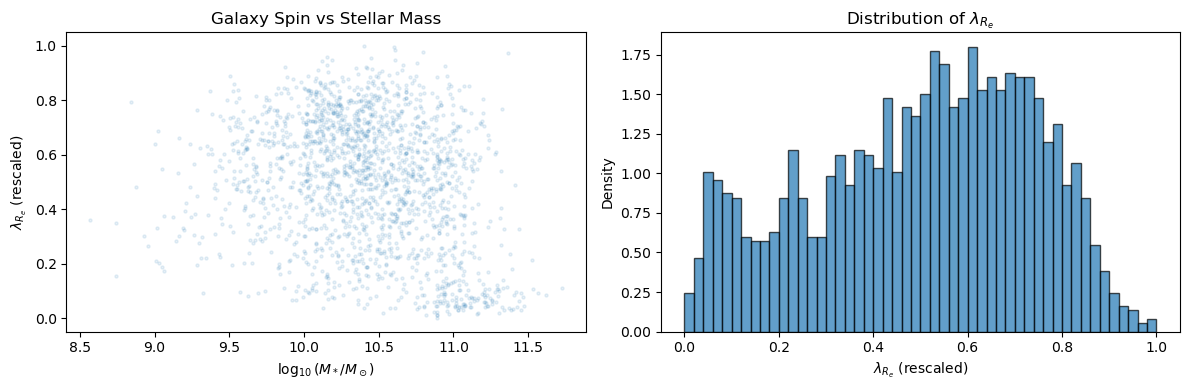

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Scatter plot
axes[0].scatter(mass, y, alpha=0.1, s=5)
axes[0].set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
axes[0].set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
axes[0].set_title('Galaxy Spin vs Stellar Mass')

# Histogram of lambda_Re
axes[1].hist(y, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[1].set_xlabel(r'$\lambda_{R_e}$ (rescaled)')
axes[1].set_ylabel('Density')
axes[1].set_title(r'Distribution of $\lambda_{R_e}$')

plt.tight_layout()
plt.show()

Looking at the histogram, there appears to be a peak around $\lambda_{R_e} \sim 0.6$ (fast rotators) and possibly a secondary population at low $\lambda_{R_e}$ (slow rotators). But is this second population real, or just the tail of a single distribution?

This is exactly the kind of question that Bayesian model comparison can answer.

## 2. The Models

We will compare three models of increasing complexity:

### Model 1: Single Beta Distribution
$$P(\lambda | \alpha, \beta) = \text{Beta}(\lambda; \alpha, \beta)$$

All galaxies are drawn from a single population. Parameters: $\alpha$, $\beta$.

### Model 2: Two Beta Distributions (Fixed Mixture)
$$P(\lambda | \theta) = f \cdot \text{Beta}(\lambda; \alpha_1, \beta_1) + (1-f) \cdot \text{Beta}(\lambda; \alpha_2, \beta_2)$$

Two populations with a fixed mixture fraction $f$. Parameters: $\alpha_1$, $\beta_1$, $\alpha_2$, $\beta_2$, $f$.

### Model 3: Two Beta Distributions (Mass-Dependent Mixture)
$$P(\lambda | M_*, \theta) = f(M_*) \cdot \text{Beta}(\lambda; \alpha_1, \beta_1) + (1-f(M_*)) \cdot \text{Beta}(\lambda; \alpha_2, \beta_2)$$

where
$$f(M_*) = \sigma(a \cdot (\log M_* - M_0))$$

and $\sigma$ is the sigmoid function. The fraction of slow rotators increases with stellar mass. Parameters: $\alpha_1$, $\beta_1$, $\alpha_2$, $\beta_2$, $a$, $M_0$.

<div class="alert alert-info">
<b>Note:</b> The original paper by van de Sande et al. used a more sophisticated model where the beta parameters themselves varied linearly with mass. We use a simplified version here for pedagogical clarity, but the principle is the same.
</div>

### Quick Beta Distribution Refresher

The beta distribution is perfect for modelling data bounded between 0 and 1. Its shape is controlled by parameters $\alpha$ and $\beta$:
- $\alpha > 1, \beta > 1$: bell-shaped
- $\alpha < 1, \beta < 1$: U-shaped
- $\alpha > \beta$: skewed toward 1
- $\alpha < \beta$: skewed toward 0

The mean is $\alpha / (\alpha + \beta)$.

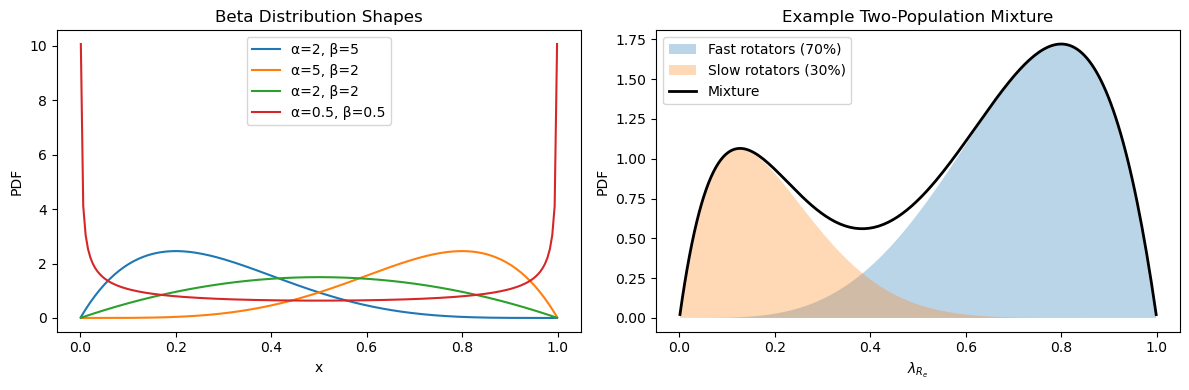

In [9]:
# Demonstrate beta distributions
x_plot = np.linspace(0.001, 0.999, 200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Different shapes
params = [(2, 5), (5, 2), (2, 2), (0.5, 0.5)]
for a, b in params:
    axes[0].plot(x_plot, stats.beta.pdf(x_plot, a, b), label=f'α={a}, β={b}')
axes[0].set_xlabel('x')
axes[0].set_ylabel('PDF')
axes[0].legend()
axes[0].set_title('Beta Distribution Shapes')

# Right: Mixture example
# Fast rotators: peaked at high lambda
fast = stats.beta.pdf(x_plot, 5, 2)
# Slow rotators: peaked at low lambda
slow = stats.beta.pdf(x_plot, 2, 8)
# Mixture
f = 0.3
mixture = f * slow + (1-f) * fast

axes[1].fill_between(x_plot, (1-f)*fast, alpha=0.3, label='Fast rotators (70%)')
axes[1].fill_between(x_plot, f*slow, alpha=0.3, label='Slow rotators (30%)')
axes[1].plot(x_plot, mixture, 'k-', lw=2, label='Mixture')
axes[1].set_xlabel(r'$\lambda_{R_e}$')
axes[1].set_ylabel('PDF')
axes[1].legend()
axes[1].set_title('Example Two-Population Mixture')

plt.tight_layout()
plt.show()

## 3. Setting Up the Nested Sampling

For each model, we need:
1. A **log-likelihood function**: $\ln \mathcal{L}(\theta) = \sum_i \ln P(\lambda_i | \theta)$
2. A **prior transform**: maps the unit hypercube to our prior ranges

### Prior Choices

We use weakly informative priors:
- $\alpha, \beta \sim \text{Uniform}(0.5, 10)$ — allows various shapes but excludes extreme values
- $f \sim \text{Uniform}(0, 1)$ — agnostic about mixture fraction
- $a \sim \text{Uniform}(-5, 5)$ — allows increasing or decreasing with mass
- $M_0 \sim \text{Uniform}(9, 12)$ — covers the mass range

In [11]:
################################
# MODEL 1: Single Beta Distribution
################################

def log_likelihood_M1(theta):
    """
    Log-likelihood for single beta distribution.
    theta = [alpha, beta]
    """
    alpha, beta = theta
    
    # Beta log-PDF: (alpha-1)*log(x) + (beta-1)*log(1-x) - log(B(alpha,beta))
    log_pdf = (alpha - 1) * np.log(y) + (beta - 1) * np.log(1 - y) - betaln(alpha, beta)
    
    return np.sum(log_pdf)


def prior_transform_M1(u):
    """
    Transform unit cube to prior.
    u = [u_alpha, u_beta] in [0,1]^2
    """
    alpha = 0.5 + u[0] * 9.5   # Uniform(0.5, 10)
    beta = 0.5 + u[1] * 9.5    # Uniform(0.5, 10)
    return np.array([alpha, beta])

In [28]:
################################
# MODEL 2: Two Betas, Fixed Mixture
################################

def log_likelihood_M2(theta):
    """
    Log-likelihood for two-beta mixture with fixed fraction.
    theta = [alpha1, beta1, alpha2, beta2, f]
    
    Component 1: Fast rotators (high lambda)
    Component 2: Slow rotators (low lambda)
    f: fraction of slow rotators
    """
    alpha1, beta1, alpha2, beta2, f = theta
    
    # PDF for each component
    pdf1 = stats.beta.pdf(y, alpha1, beta1)  # Fast rotators
    pdf2 = stats.beta.pdf(y, alpha2, beta2)  # Slow rotators
    
    # Mixture
    mixture_pdf = (1 - f) * pdf1 + f * pdf2
    
    # Avoid log(0)
    mixture_pdf = np.maximum(mixture_pdf, 1e-300)
    
    return np.sum(np.log(mixture_pdf))


# def prior_transform_M2(u):
#     """
#     Transform unit cube to prior.
#     u = [u_a1, u_b1, u_a2, u_b2, u_f]
#     """
#     alpha1 = 0.5 + u[0] * 9.5  # Fast rotators alpha
#     beta1 = 0.5 + u[1] * 9.5   # Fast rotators beta
#     alpha2 = 0.5 + u[2] * 9.5  # Slow rotators alpha
#     beta2 = 0.5 + u[3] * 9.5   # Slow rotators beta
#     f = u[4]                    # Mixture fraction (0 to 1)
#     return np.array([alpha1, beta1, alpha2, beta2, f])


def prior_transform_M2(u):
    alpha1 = 0.5 + u[0] * 9.5
    beta1 = 0.5 + u[1] * 9.5
    alpha2 = 0.5 + u[2] * 9.5
    beta2 = 0.5 + u[3] * 9.5
    f = u[4]
    
    # Enforce ordering: mean1 > mean2
    mean1 = alpha1 / (alpha1 + beta1)
    mean2 = alpha2 / (alpha2 + beta2)
    
    if mean1 < mean2:
        # Swap components
        alpha1, alpha2 = alpha2, alpha1
        beta1, beta2 = beta2, beta1
        f = 1 - f
    
    return np.array([alpha1, beta1, alpha2, beta2, f])


In [13]:
################################
# MODEL 3: Two Betas, Mass-Dependent Mixture
################################

def sigmoid(x):
    """Numerically stable sigmoid."""
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))


def log_likelihood_M3(theta):
    """
    Log-likelihood for two-beta mixture with mass-dependent fraction.
    theta = [alpha1, beta1, alpha2, beta2, a, M0]
    
    f(M) = sigmoid(a * (log M - M0))
    f is the fraction of SLOW rotators
    """
    alpha1, beta1, alpha2, beta2, a, M0 = theta
    
    # Mass-dependent mixture fraction
    f = sigmoid(a * (mass - M0))
    
    # PDF for each component
    pdf1 = stats.beta.pdf(y, alpha1, beta1)  # Fast rotators
    pdf2 = stats.beta.pdf(y, alpha2, beta2)  # Slow rotators
    
    # Mixture (f varies per galaxy based on mass)
    mixture_pdf = (1 - f) * pdf1 + f * pdf2
    
    # Avoid log(0)
    mixture_pdf = np.maximum(mixture_pdf, 1e-300)
    
    return np.sum(np.log(mixture_pdf))


def prior_transform_M3(u):
    """
    Transform unit cube to prior.
    u = [u_a1, u_b1, u_a2, u_b2, u_a, u_M0]
    """
    alpha1 = 0.5 + u[0] * 9.5   # Fast rotators alpha
    beta1 = 0.5 + u[1] * 9.5    # Fast rotators beta
    alpha2 = 0.5 + u[2] * 9.5   # Slow rotators alpha
    beta2 = 0.5 + u[3] * 9.5    # Slow rotators beta
    a = -5 + u[4] * 10          # Slope: Uniform(-5, 5)
    M0 = 9 + u[5] * 3           # Transition mass: Uniform(9, 12)
    return np.array([alpha1, beta1, alpha2, beta2, a, M0])

## 4. Running Nested Sampling

Now we run `dynesty` on each model. This will:
1. Explore the parameter space
2. Compute the evidence $\mathcal{Z}$ for each model
3. Give us posterior samples for the parameters

<div class="alert alert-warning">
<b>Note:</b> This may take a few minutes to run, especially for the more complex models.
</div>

In [38]:
################################
# Run Model 1
################################
print("Running Model 1 (Single Beta)...")

sampler_M1 = dynesty.NestedSampler(
    log_likelihood_M1,
    prior_transform_M1,
    ndim=2,
    nlive=350
)
sampler_M1.run_nested(print_progress=True)
results_M1 = sampler_M1.results

print(f"\nModel 1: log(Z) = {results_M1.logz[-1]:.2f} +/- {results_M1.logzerr[-1]:.2f}")

Running Model 1 (Single Beta)...


3578it [00:03, 1056.80it/s, +350 | bound: 11 | nc: 1 | ncall: 16494 | eff(%): 24.331 | loglstar:   -inf < 144.522 <    inf | logz: 135.472 +/-  0.151 | dlogz:  0.001 >  0.359]


Model 1: log(Z) = 135.47 +/- 0.25


In [40]:
################################
# Run Model 2
################################
print("Running Model 2 (Two Betas, Fixed Mixture)...")

sampler_M2 = dynesty.NestedSampler(
    log_likelihood_M2,
    prior_transform_M2,
    ndim=5,
    nlive=350,
    sample = 'rwalk'
)
sampler_M2.run_nested(print_progress=True)
results_M2 = sampler_M2.results

print(f"\nModel 2: log(Z) = {results_M2.logz[-1]:.2f} +/- {results_M2.logzerr[-1]:.2f}")

Running Model 2 (Two Betas, Fixed Mixture)...


5616it [01:23, 67.39it/s, +350 | bound: 16 | nc: 1 | ncall: 122333 | eff(%):  4.891 | loglstar:   -inf < 219.185 <    inf | logz: 204.199 +/-  0.202 | dlogz:  0.001 >  0.359]


Model 2: log(Z) = 204.20 +/- 0.31


In [42]:
################################
# Run Model 3
################################
print("Running Model 3 (Two Betas, Mass-Dependent Mixture)...")

sampler_M3 = dynesty.NestedSampler(
    log_likelihood_M3,
    prior_transform_M3,
    ndim=6,
    nlive=350,
    sample = 'rwalk'
)
sampler_M3.run_nested(print_progress=True)
results_M3 = sampler_M3.results

print(f"\nModel 3: log(Z) = {results_M3.logz[-1]:.2f} +/- {results_M3.logzerr[-1]:.2f}")

Running Model 3 (Two Betas, Mass-Dependent Mixture)...


7724it [02:06, 61.03it/s, +350 | bound: 23 | nc: 1 | ncall: 181286 | eff(%):  4.462 | loglstar:   -inf < 330.532 <    inf | logz: 309.475 +/-  0.240 | dlogz:  0.001 >  0.359]


Model 3: log(Z) = 309.47 +/- 0.35


## 5. Model Comparison

Now for the payoff! We can compute:
1. **Bayes factors** between models
2. **Model probabilities** (assuming equal prior odds)

Recall:
$$B_{ij} = \frac{\mathcal{Z}_i}{\mathcal{Z}_j}$$

$$P(M_i | D) = \frac{\mathcal{Z}_i}{\sum_j \mathcal{Z}_j}$$

In [61]:
# Extract log-evidences
logZ_M1 = results_M1.logz[-1]
logZ_M2 = results_M2.logz[-1]
logZ_M3 = results_M3.logz[-1]

logZ_err_M1 = results_M1.logzerr[-1]
logZ_err_M2 = results_M2.logzerr[-1]
logZ_err_M3 = results_M3.logzerr[-1]

print("="*50)
print("LOG-EVIDENCES")
print("="*50)
print(f"Model 1 (Single Beta):           log(Z) = {logZ_M1:.2f} ± {logZ_err_M1:.2f}")
print(f"Model 2 (Two Betas, Fixed f):    log(Z) = {logZ_M2:.2f} ± {logZ_err_M2:.2f}")
print(f"Model 3 (Two Betas, f(M)):       log(Z) = {logZ_M3:.2f} ± {logZ_err_M3:.2f}")

LOG-EVIDENCES
Model 1 (Single Beta):           log(Z) = 135.47 ± 0.25
Model 2 (Two Betas, Fixed f):    log(Z) = 204.20 ± 0.31
Model 3 (Two Betas, f(M)):       log(Z) = 309.47 ± 0.35


In [63]:
# Bayes factors (relative to Model 1)
log_BF_21 = logZ_M2 - logZ_M1
log_BF_31 = logZ_M3 - logZ_M1
log_BF_32 = logZ_M3 - logZ_M2

print("\n" + "="*50)
print("BAYES FACTORS")
print("="*50)
print(f"B_21 (Model 2 vs Model 1): {np.exp(log_BF_21):.2e}  [log = {log_BF_21:.1f}]")
print(f"B_31 (Model 3 vs Model 1): {np.exp(log_BF_31):.2e}  [log = {log_BF_31:.1f}]")
print(f"B_32 (Model 3 vs Model 2): {np.exp(log_BF_32):.2e}  [log = {log_BF_32:.1f}]")


BAYES FACTORS
B_21 (Model 2 vs Model 1): 7.05e+29  [log = 68.7]
B_31 (Model 3 vs Model 1): 3.70e+75  [log = 174.0]
B_32 (Model 3 vs Model 2): 5.25e+45  [log = 105.3]


In [65]:
# Model probabilities (assuming equal prior odds)
# Work in log space for numerical stability
log_Zs = np.array([logZ_M1, logZ_M2, logZ_M3])
log_Z_max = np.max(log_Zs)
log_Z_total = log_Z_max + np.log(np.sum(np.exp(log_Zs - log_Z_max)))

P_M1 = np.exp(logZ_M1 - log_Z_total)
P_M2 = np.exp(logZ_M2 - log_Z_total)
P_M3 = np.exp(logZ_M3 - log_Z_total)

print("\n" + "="*50)
print("MODEL PROBABILITIES (assuming equal priors)")
print("="*50)
print(f"P(Model 1 | Data) = {P_M1:.4f}  ({P_M1*100:.2f}%)")
print(f"P(Model 2 | Data) = {P_M2:.4f}  ({P_M2*100:.2f}%)")
print(f"P(Model 3 | Data) = {P_M3:.4f}  ({P_M3*100:.2f}%)")


MODEL PROBABILITIES (assuming equal priors)
P(Model 1 | Data) = 0.0000  (0.00%)
P(Model 2 | Data) = 0.0000  (0.00%)
P(Model 3 | Data) = 1.0000  (100.00%)


### Interpreting Bayes Factors

A common scale for interpreting Bayes factors (Kass & Raftery 1995):

| $\log_{10} B_{ij}$ | $B_{ij}$ | Evidence against Model j |
|:---:|:---:|:---:|
| 0 to 0.5 | 1 to 3 | Not worth more than a bare mention |
| 0.5 to 1 | 3 to 10 | Substantial |
| 1 to 2 | 10 to 100 | Strong |
| > 2 | > 100 | Decisive |

Note: these are in $\log_{10}$. To convert from natural log: $\log_{10} B = \ln B / \ln 10 \approx \ln B / 2.3$

In [67]:
# Convert to log10 for interpretation
log10_BF_21 = log_BF_21 / np.log(10)
log10_BF_31 = log_BF_31 / np.log(10)
log10_BF_32 = log_BF_32 / np.log(10)

print("\nBayes factors in log10:")
print(f"  log10(B_21) = {log10_BF_21:.1f}")
print(f"  log10(B_31) = {log10_BF_31:.1f}")
print(f"  log10(B_32) = {log10_BF_32:.1f}")


Bayes factors in log10:
  log10(B_21) = 29.8
  log10(B_31) = 75.6
  log10(B_32) = 45.7


## 6. Parameter Posteriors

Let's examine the posterior distributions for the best model's parameters.

Best model: Model 3 (Two Betas, f(M))


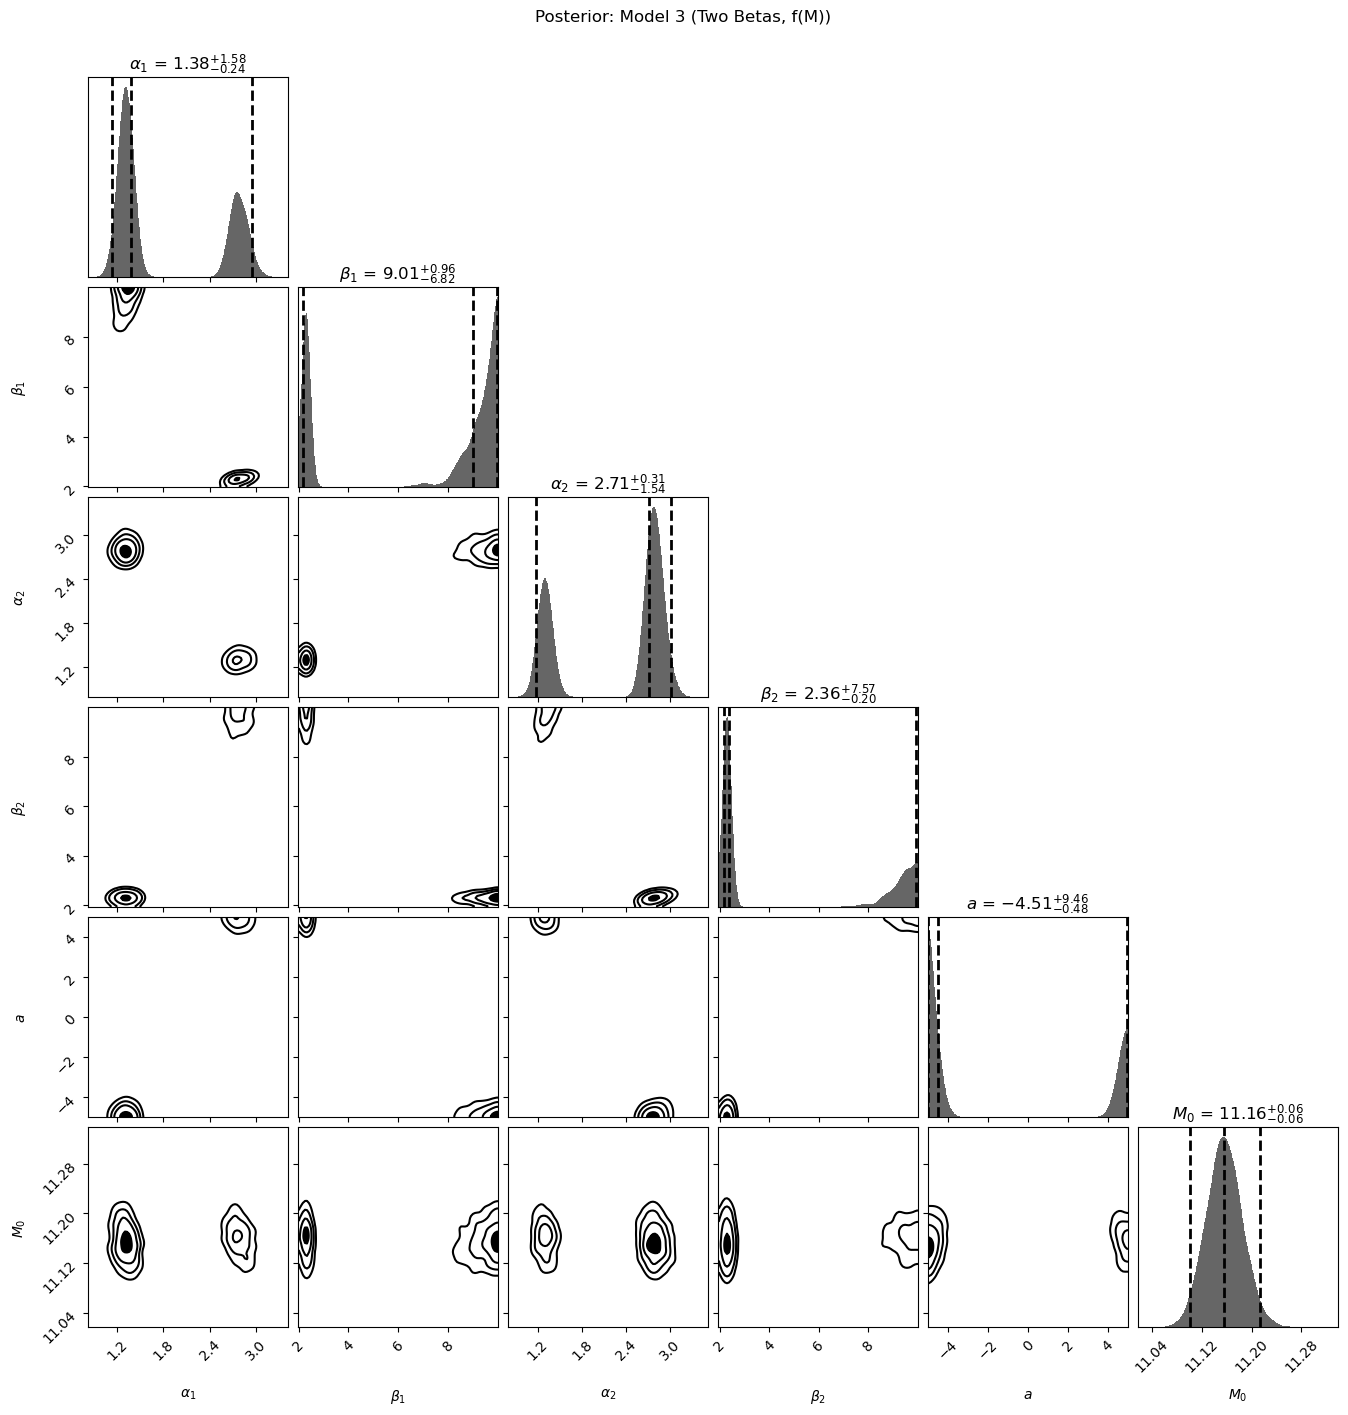

In [69]:
# Identify best model
best_idx = np.argmax([logZ_M1, logZ_M2, logZ_M3])
model_names = ['Model 1 (Single Beta)', 'Model 2 (Two Betas, Fixed)', 'Model 3 (Two Betas, f(M))']
results_list = [results_M1, results_M2, results_M3]
param_labels_list = [
    [r'$\alpha$', r'$\beta$'],
    [r'$\alpha_1$', r'$\beta_1$', r'$\alpha_2$', r'$\beta_2$', r'$f$'],
    [r'$\alpha_1$', r'$\beta_1$', r'$\alpha_2$', r'$\beta_2$', r'$a$', r'$M_0$']
]

print(f"Best model: {model_names[best_idx]}")

# Corner plot for best model
fig, axes = dyplot.cornerplot(
    results_list[best_idx],
    labels=param_labels_list[best_idx],
    show_titles=True,
    title_kwargs={'fontsize': 12}
)
plt.suptitle(f'Posterior: {model_names[best_idx]}', y=1.02)
plt.show()

## 7. Visualising the Best-Fit Model

Let's overlay the best-fit model on the data.

In [71]:
# Get posterior samples and weights for best model
best_results = results_list[best_idx]
samples = best_results.samples
weights = np.exp(best_results.logwt - best_results.logz[-1])

# Weighted mean parameters
mean_params = np.average(samples, weights=weights, axis=0)

print(f"Mean parameters for {model_names[best_idx]}:")
for i, (label, val) in enumerate(zip(param_labels_list[best_idx], mean_params)):
    print(f"  {label} = {val:.3f}")
    
if best_idx == 2:
    alpha1, beta1, alpha2, beta2, a, M0 = mean_params
    print(f"\nTransition mass (f = 0.5): log(M*/M☉) = {M0:.2f}")
    
    # Or get the full posterior on M0
    M0_samples = samples[:, 5]
    M0_median = np.percentile(M0_samples, 50)
    M0_lo, M0_hi = np.percentile(M0_samples, [16, 84])
    print(f"M0 = {M0_median:.2f} (+{M0_hi-M0_median:.2f} / -{M0_median-M0_lo:.2f})")

Mean parameters for Model 3 (Two Betas, f(M)):
  $\alpha_1$ = 1.819
  $\beta_1$ = 6.911
  $\alpha_2$ = 2.279
  $\beta_2$ = 4.720
  $a$ = -1.463
  $M_0$ = 11.156

Transition mass (f = 0.5): log(M*/M☉) = 11.16
M0 = 11.14 (+0.11 / -0.48)


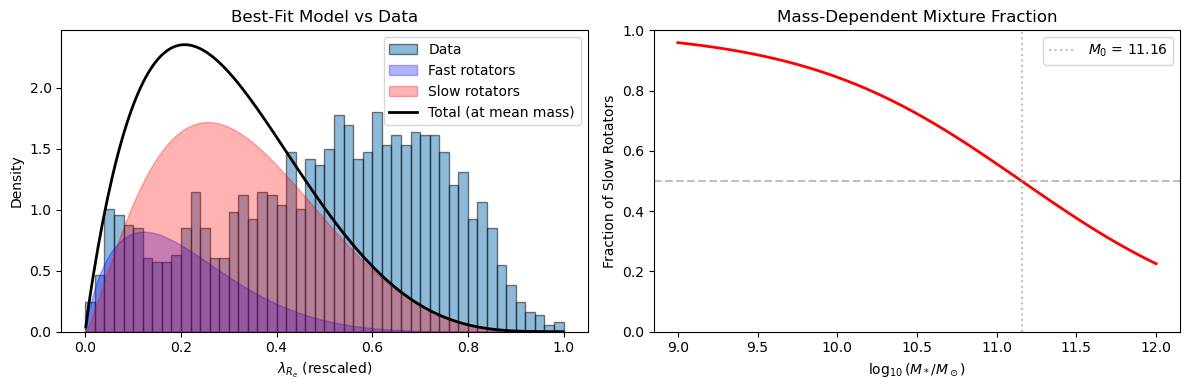

In [73]:
x_plot = np.linspace(0.001, 0.999, 200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Overall distribution
axes[0].hist(y, bins=50, density=True, alpha=0.5, edgecolor='black', label='Data')

if best_idx == 0:
    # Single beta
    alpha, beta = mean_params
    pdf = stats.beta.pdf(x_plot, alpha, beta)
    axes[0].plot(x_plot, pdf, 'r-', lw=2, label='Best fit')
    
elif best_idx == 1:
    # Two betas, fixed mixture
    alpha1, beta1, alpha2, beta2, f = mean_params
    pdf1 = stats.beta.pdf(x_plot, alpha1, beta1)
    pdf2 = stats.beta.pdf(x_plot, alpha2, beta2)
    mixture = (1-f) * pdf1 + f * pdf2
    axes[0].fill_between(x_plot, (1-f)*pdf1, alpha=0.3, color='blue', label=f'Fast rotators ({(1-f)*100:.0f}%)')
    axes[0].fill_between(x_plot, f*pdf2, alpha=0.3, color='red', label=f'Slow rotators ({f*100:.0f}%)')
    axes[0].plot(x_plot, mixture, 'k-', lw=2, label='Total')
    
else:
    # Two betas, mass-dependent (show for mean mass)
    alpha1, beta1, alpha2, beta2, a, M0 = mean_params
    f_mean = sigmoid(a * (np.mean(mass) - M0))
    pdf1 = stats.beta.pdf(x_plot, alpha1, beta1)
    pdf2 = stats.beta.pdf(x_plot, alpha2, beta2)
    mixture = (1-f_mean) * pdf1 + f_mean * pdf2
    axes[0].fill_between(x_plot, (1-f_mean)*pdf1, alpha=0.3, color='blue', label='Fast rotators')
    axes[0].fill_between(x_plot, f_mean*pdf2, alpha=0.3, color='red', label='Slow rotators')
    axes[0].plot(x_plot, mixture, 'k-', lw=2, label=f'Total (at mean mass)')

axes[0].set_xlabel(r'$\lambda_{R_e}$ (rescaled)')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].set_title('Best-Fit Model vs Data')

# Right: For Model 3, show how mixture fraction varies with mass
if best_idx == 2:
    mass_range = np.linspace(9, 12, 100)
    f_mass = sigmoid(a * (mass_range - M0))
    axes[1].plot(mass_range, f_mass, 'r-', lw=2)
    axes[1].axhline(0.5, ls='--', color='gray', alpha=0.5)
    axes[1].axvline(M0, ls=':', color='gray', alpha=0.5, label=f'$M_0$ = {M0:.2f}')
    axes[1].set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
    axes[1].set_ylabel('Fraction of Slow Rotators')
    axes[1].set_title('Mass-Dependent Mixture Fraction')
    axes[1].legend()
    axes[1].set_ylim(0, 1)
else:
    axes[1].axis('off')
    axes[1].text(0.5, 0.5, 'Mass-dependent plot\nonly for Model 3', 
                 ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

## 8. Summary

We have performed Bayesian model comparison using nested sampling to determine whether the distribution of galaxy spin parameters requires one or two distinct populations.

**Key takeaways:**

1. **Nested sampling** gives us both the evidence $\mathcal{Z}$ and posterior samples in one run

2. **Bayes factors** directly answer "which model is better supported by the data?"

3. **Model probabilities** give us quantitative answers like "there is a 95% probability that the two-population model is correct"

4. The evidence naturally **penalises complexity**: a more complex model must fit the data substantially better to overcome the "Occam penalty" from having more free parameters

5. Unlike frequentist approaches (p-values, AIC, BIC), Bayesian model comparison:
   - Answers the question we actually care about: $P(M_i | D)$
   - Works for non-nested models
   - Properly accounts for prior information
   - Gives probabilistic, not just ordinal, comparisons

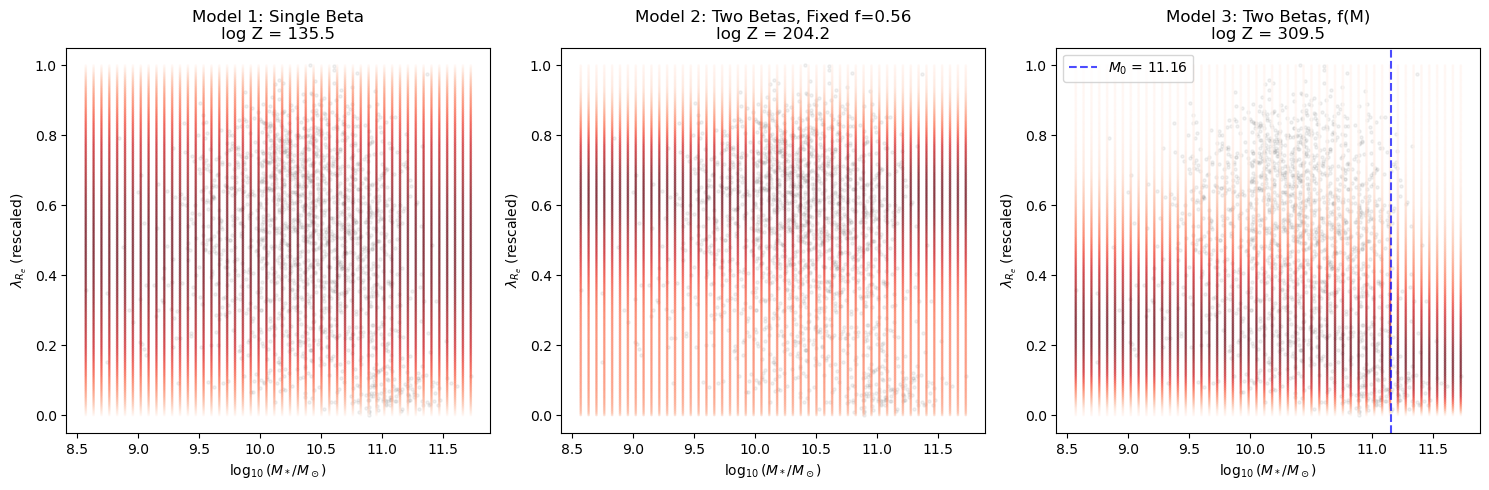

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x_plot = np.linspace(0.001, 0.999, 200)

# Get mean parameters for each model
weights_M1 = np.exp(results_M1.logwt - results_M1.logz[-1])
weights_M2 = np.exp(results_M2.logwt - results_M2.logz[-1])
weights_M3 = np.exp(results_M3.logwt - results_M3.logz[-1])

params_M1 = np.average(results_M1.samples, weights=weights_M1, axis=0)
params_M2 = np.average(results_M2.samples, weights=weights_M2, axis=0)
params_M3 = np.average(results_M3.samples, weights=weights_M3, axis=0)

mass_grid = np.linspace(mass.min(), mass.max(), 50)

# Model 1
ax = axes[0]
ax.scatter(mass, y, alpha=0.1, s=5, c='grey')
pdf_M1 = stats.beta.pdf(x_plot, params_M1[0], params_M1[1])
for m in mass_grid:
    ax.scatter(np.full_like(x_plot, m), x_plot, c=pdf_M1/pdf_M1.max(), cmap='Reds', s=1, alpha=0.5)
ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
ax.set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
ax.set_title(f'Model 1: Single Beta\nlog Z = {results_M1.logz[-1]:.1f}')

# Model 2
ax = axes[1]
ax.scatter(mass, y, alpha=0.1, s=5, c='grey')
alpha1, beta1, alpha2, beta2, f = params_M2
pdf1 = stats.beta.pdf(x_plot, alpha1, beta1)
pdf2 = stats.beta.pdf(x_plot, alpha2, beta2)
mixture = (1-f) * pdf1 + f * pdf2
for m in mass_grid:
    ax.scatter(np.full_like(x_plot, m), x_plot, c=mixture/mixture.max(), cmap='Reds', s=1, alpha=0.5)
ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
ax.set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
ax.set_title(f'Model 2: Two Betas, Fixed f={f:.2f}\nlog Z = {results_M2.logz[-1]:.1f}')

# Model 3
ax = axes[2]
ax.scatter(mass, y, alpha=0.1, s=5, c='grey')
alpha1, beta1, alpha2, beta2, a, M0 = params_M3
pdf1 = stats.beta.pdf(x_plot, alpha1, beta1)
pdf2 = stats.beta.pdf(x_plot, alpha2, beta2)

for m in mass_grid:
    f_m = sigmoid(a * (m - M0))
    mixture = (1 - f_m) * pdf1 + f_m * pdf2
    ax.scatter(np.full_like(x_plot, m), x_plot, c=mixture/mixture.max(), cmap='Reds', s=1, alpha=0.5)

ax.axvline(M0, ls='--', c='blue', alpha=0.7, label=f'$M_0$ = {M0:.2f}')
ax.legend()
ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
ax.set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
ax.set_title(f'Model 3: Two Betas, f(M)\nlog Z = {results_M3.logz[-1]:.1f}')

plt.tight_layout()
plt.show()

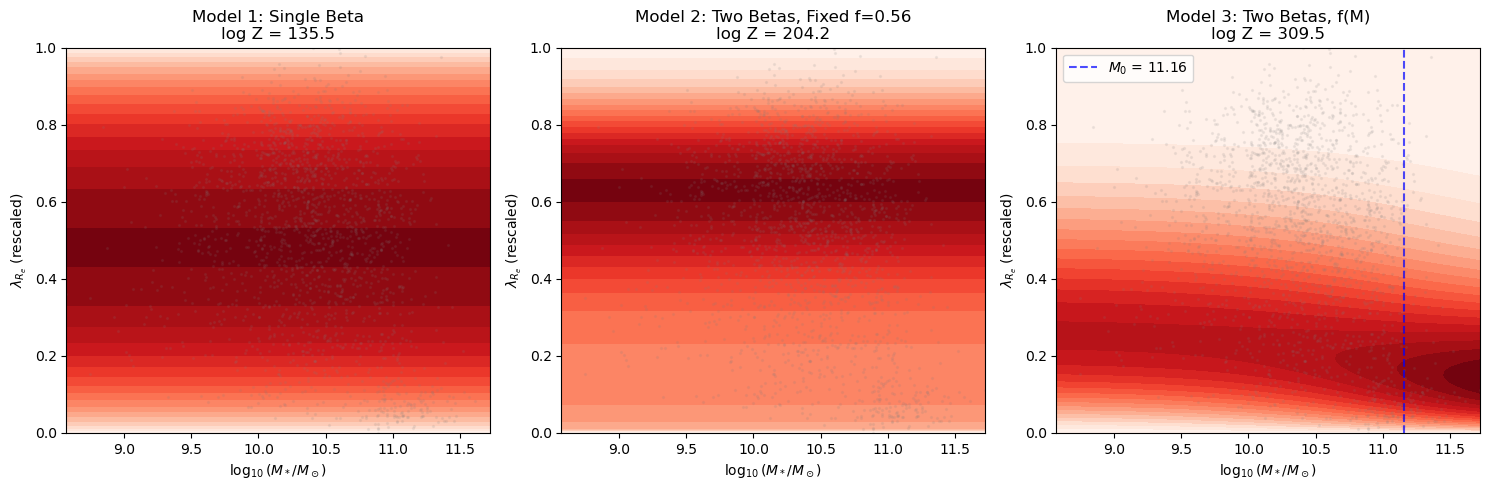

In [79]:
from scipy.ndimage import gaussian_filter

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Grid for evaluation
mass_grid = np.linspace(mass.min(), mass.max(), 100)
lambda_grid = np.linspace(0, 1, 100)
M, L = np.meshgrid(mass_grid, lambda_grid)

# Get mean parameters for each model
weights_M1 = np.exp(results_M1.logwt - results_M1.logz[-1])
weights_M2 = np.exp(results_M2.logwt - results_M2.logz[-1])
weights_M3 = np.exp(results_M3.logwt - results_M3.logz[-1])

params_M1 = np.average(results_M1.samples, weights=weights_M1, axis=0)
params_M2 = np.average(results_M2.samples, weights=weights_M2, axis=0)
params_M3 = np.average(results_M3.samples, weights=weights_M3, axis=0)

# Model 1: Single beta (no mass dependence)
ax = axes[0]
pdf_M1 = stats.beta.pdf(L, params_M1[0], params_M1[1])
ax.contourf(M, L, pdf_M1, levels=20, cmap='Reds')
ax.scatter(mass, y, alpha=0.1, s=2, c='grey')
ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
ax.set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
ax.set_title(f'Model 1: Single Beta\nlog Z = {results_M1.logz[-1]:.1f}')

# Model 2: Two betas, fixed mixture
ax = axes[1]
alpha1, beta1, alpha2, beta2, f = params_M2
pdf1 = stats.beta.pdf(L, alpha1, beta1)
pdf2 = stats.beta.pdf(L, alpha2, beta2)
pdf_M2 = (1-f) * pdf1 + f * pdf2
ax.contourf(M, L, pdf_M2, levels=20, cmap='Reds')
ax.scatter(mass, y, alpha=0.1, s=2, c='grey')
ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
ax.set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
ax.set_title(f'Model 2: Two Betas, Fixed f={f:.2f}\nlog Z = {results_M2.logz[-1]:.1f}')

# Model 3: Two betas, mass-dependent mixture
ax = axes[2]
alpha1, beta1, alpha2, beta2, a, M0 = params_M3
pdf1 = stats.beta.pdf(L, alpha1, beta1)
pdf2 = stats.beta.pdf(L, alpha2, beta2)
f_M = sigmoid(a * (M - M0))
pdf_M3 = (1 - f_M) * pdf1 + f_M * pdf2
ax.contourf(M, L, pdf_M3, levels=20, cmap='Reds')
ax.scatter(mass, y, alpha=0.1, s=2, c='grey')
ax.axvline(M0, ls='--', c='blue', alpha=0.7, label=f'$M_0$ = {M0:.2f}')
ax.legend()
ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
ax.set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
ax.set_title(f'Model 3: Two Betas, f(M)\nlog Z = {results_M3.logz[-1]:.1f}')

plt.tight_layout()
plt.show()

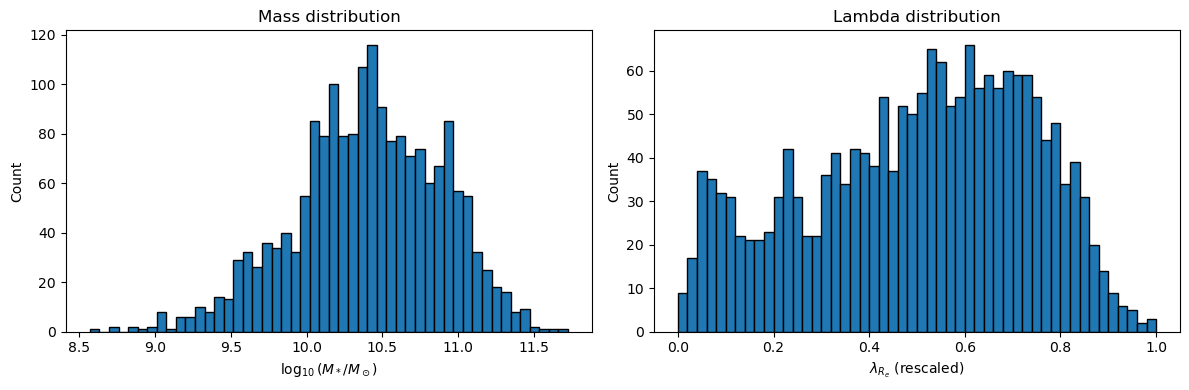

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(mass, bins=50, edgecolor='black')
axes[0].set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
axes[0].set_ylabel('Count')
axes[0].set_title('Mass distribution')

axes[1].hist(y, bins=50, edgecolor='black')
axes[1].set_xlabel(r'$\lambda_{R_e}$ (rescaled)')
axes[1].set_ylabel('Count')
axes[1].set_title('Lambda distribution')

plt.tight_layout()
plt.show()

## Exercises

1. **Prior sensitivity**: Change the prior ranges on $\alpha$ and $\beta$. How does this affect the evidence and model probabilities? Why?

2. **More complex models**: The original paper allowed the beta parameters to vary with mass. Implement a model where $\alpha_1$ and $\beta_1$ are linear functions of mass. Does this improve the evidence?

3. **Subset analysis**: Run the analysis on only high-mass galaxies ($\log M_* > 10.5$). How do the results change?

4. **Posterior predictive checks**: Sample from the posterior and generate fake datasets. Do they look like the real data?